In [1]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive/')

movies = pd.read_csv('/content/drive/My Drive/movies.csv')
ratings = pd.read_csv('/content/drive/My Drive/ratings.csv')
tags = pd.read_csv('/content/drive/My Drive/tags.csv')

rating=ratings.drop(['userId','timestamp'],axis=1)
tag=tags.drop(['userId','timestamp'],axis=1)

Mounted at /content/drive/


In [2]:
tag=pd.DataFrame(tag.groupby('movieId')['tag'].apply(list))

In [3]:
metadata=movies.merge(rating,on='movieId')
metadata=metadata.merge(tag,on='movieId',how='left')
metadata


,movieId,title,genres,rating,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,"[pixar, pixar, fun]"
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,"[pixar, pixar, fun]"
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5,"[pixar, pixar, fun]"
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.5,"[pixar, pixar, fun]"
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5,"[pixar, pixar, fun]"
...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4.0,NaN
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.5,NaN
100833,193585,Flint (2017),Drama,3.5,NaN
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.5,NaN


In [4]:
def clean_data(x):
    if isinstance(x, str):
        return str.lower(x.replace('|',',')) #cleaning up | in the data

metadata['genres']=metadata['genres'].apply(clean_data)
metadata

,movieId,title,genres,rating,tag
0,1,Toy Story (1995),"adventure,animation,children,comedy,fantasy",4.0,"[pixar, pixar, fun]"
1,1,Toy Story (1995),"adventure,animation,children,comedy,fantasy",4.0,"[pixar, pixar, fun]"
2,1,Toy Story (1995),"adventure,animation,children,comedy,fantasy",4.5,"[pixar, pixar, fun]"
3,1,Toy Story (1995),"adventure,animation,children,comedy,fantasy",2.5,"[pixar, pixar, fun]"
4,1,Toy Story (1995),"adventure,animation,children,comedy,fantasy",4.5,"[pixar, pixar, fun]"
...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),"action,animation,comedy,fantasy",4.0,NaN
100832,193583,No Game No Life: Zero (2017),"animation,comedy,fantasy",3.5,NaN
100833,193585,Flint (2017),drama,3.5,NaN
100834,193587,Bungo Stray Dogs: Dead Apple (2018),"action,animation",3.5,NaN


In [5]:
#put tag and genres into corpus
for i in range(len(metadata)):
  metadata['genres'][i]=metadata['genres'][i].split()

metadata['corpus']=''
for i in range(len(metadata)):
  if isinstance(metadata['tag'][i],list):
    metadata['corpus'][i]=' '.join(metadata['genres'][i]).replace(',',' ') + ' ' + ' '.join(metadata['tag'][i]).replace(',',' ')
  else:
    metadata['corpus'][i]=' '.join(metadata['genres'][i]).replace(',',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [23]:
from sklearn.utils import shuffle
metadata = shuffle(metadata)
train_set=metadata['corpus'].loc[0:int(len(metadata)*0.7-1)].values
train_label=metadata['title'].loc[0:int(len(metadata)*0.7-1)].values
test_set=metadata['corpus'].loc[int(len(metadata)*0.7):len(metadata)-1].values
test_label=metadata['title'].loc[int(len(metadata)*0.7):len(metadata)-1].values
#Might need to reshuffle the data couple of times to generate a learnable dataset due to limitation of the original data been used in this project

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import tree 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
NB_text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
NB_text_clf.fit(train_set, train_label)

predicted=NB_text_clf.predict(test_set)
np.mean(predicted == test_label)

0.3463615830305411

In [25]:
tree_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', tree.DecisionTreeClassifier()),
])
tree_clf.fit(train_set, train_label)
predicted=tree_clf.predict(test_set)
np.mean(predicted == test_label)

0.6091197747880455

In [26]:
neigh_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(3)),
])
neigh_clf.fit(train_set, train_label)
predicted=neigh_clf.predict(test_set)
np.mean(predicted == test_label)

0.5656049843420952

In [27]:
corpus=metadata['corpus'].values
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(corpus)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [28]:
from sklearn.decomposition import PCA #transform tfidf to two demensional array which readable for KMeans, EM, hierarchical clustering algorithms
pca = PCA(n_components=2)
corpus_set = pca.fit_transform(X_tfidf.toarray())

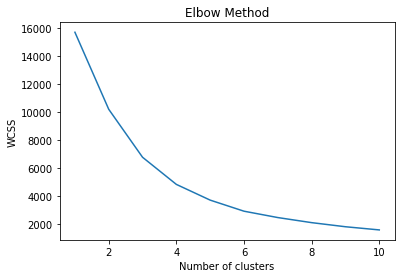

In [29]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(corpus_set)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [31]:
from gensim.models import LdaModel

# Set training parameters.
num_topics =4
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

from gensim.corpora import Dictionary

x=[doc for doc in metadata['corpus']]
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(x)):
  x[idx]=tokenizer.tokenize(x[idx])

from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(x, min_count=20)
for idx in range(len(x)):
    for token in bigram[x[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            x[idx].append(token)

from gensim.corpora import Dictionary
dictionary=Dictionary(x)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in x]

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Average topic coherence: -7.1329.


In [32]:
!pip install pyLDAvis==3.2.2
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=dictionary)
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 6.7 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135617 sha256=f209a235b70e4afd990d496cbf854e49164c6d6669ea5fa20f6402976ad991ac
  Stored in directory: /root/.cache/pip/wheels/f8/b1/9b/560ac1931796b7303f7b517b949d2d31a4fbc512aad3b9f284
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.080501 -0.223153       1        1  31.271968
2      0.231832 -0.027111       2        1  31.243702
3     -0.334763 -0.052172       3        1  27.992559
0      0.022431  0.302437       4        1   9.491770, topic_info=         Term          Freq         Total Category  logprob  loglift
7      comedy  43221.000000  43221.000000  Default  30.0000  30.0000
8          fi  20623.000000  20623.000000  Default  29.0000  29.0000
9         sci  20599.000000  20599.000000  Default  28.0000  28.0000
1    thriller  27679.000000  27679.000000  Default  27.0000  27.0000
5     romance  18368.000000  18368.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
49    mystery    652.192253   8335.089144   Topic4  -4.6311  -0.1931
910       hit    393.540570    988.496648   Topic4  -5.1362   1.4337
1    thriller    637.970445  27679.163419   Topic4  -4.6531  -1.4154
184     funny    341.428234   1544.286934   Topic4  -5.2783   0.8456
231       Tom    321.813970    545.818850   Topic4  -5.3374   1.8264

[228 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                        
61        3  0.623100                    250
61        4  0.377192                    250
246       1  0.998288                     Al
247       1  0.998288              Al_Pacino
763       4  0.998210                    Ben
...     ...       ...                    ...
265       2  0.999982                western
779       3  0.999485                   with
640       2  0.999240                  world
215       4  1.000025               wrongful
216       4  1.000025  wrongful_imprisonment

[262 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])